___

# Задача: Классификация эмоций в текстовых расшифровках голосовых сообщений

## Цель
Определить настроение говорящего, анализируя текстовую расшифровку его голосового сообщения.

## Материалы
- Текстовые расшифровки голосовых сообщений, размеченные по категориям эмоций (формат .xlsx и .csv).
- Предоставляются наборы текстов, полученных из реальных голосовых сообщений. Эти данные содержат тексты, уже аннотированные по различным эмоциональным категориям, таким как счастье, грусть, гнев и другие. При необходимости вы можете расширить датасет (данными из открытых источников, синтетическими данными).

## Что ожидает получить партнер
Модель машинного обучения, которая получает на вход текст и отдает один наиболее вероятный класс эмоции.

___

### Импорты и установка устройства

In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Загрузка и предварительная обработка данных

In [4]:
data = pd.read_csv('phrases.csv')

# Очистка текста
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

data['Текст фразы'] = data['Текст фразы'].apply(preprocess_text)

# Удаление эмоции "Недовольство"
data = data[data['Эмоция'] != 'Недовольство']

### EDA (Исследовательский анализ данных) - краткий

<class 'pandas.core.frame.DataFrame'>
Index: 1028 entries, 15 to 1042
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Текст фразы  1028 non-null   object
 1   Эмоция       1028 non-null   object
dtypes: object(2)
memory usage: 24.1+ KB
None
                                              Текст фразы      Эмоция
count                                                1028        1028
unique                                               1024           7
top     Я очень рада что вы нашли в себе силы обратить...  Нейтрально
freq                                                    2         204
Эмоция
Нейтрально    204
Радость       163
Сочувствие    145
Злость        141
Печаль        133
Зависть       125
Интерес       117
Name: count, dtype: int64


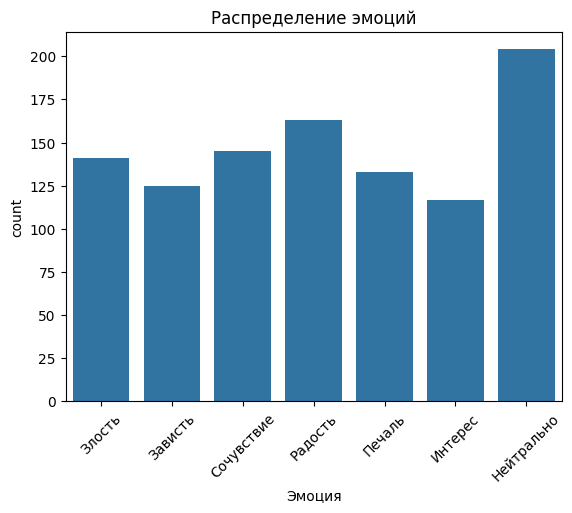

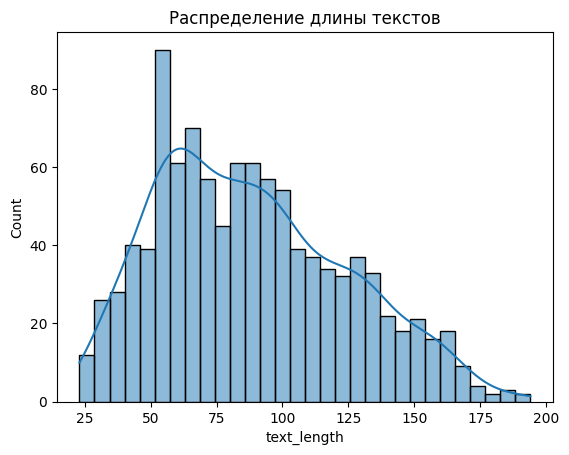

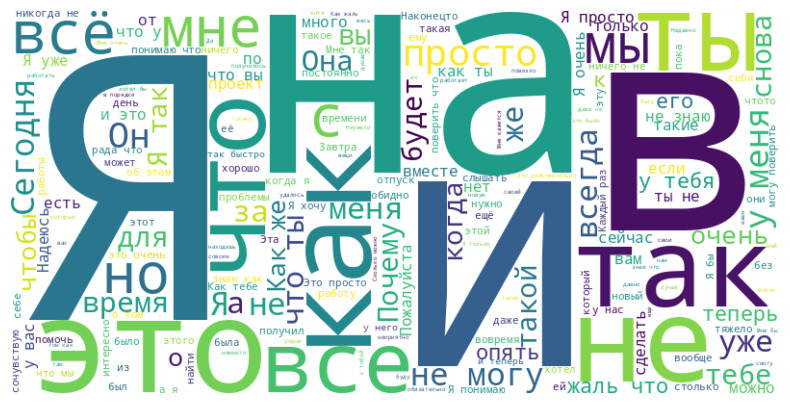

In [5]:
print(data.info())
print(data.describe())
print(data['Эмоция'].value_counts())

# Распределение эмоций
sns.countplot(data=data, x='Эмоция')
plt.title("Распределение эмоций")
plt.xticks(rotation=45)
plt.show()

# Длина текстов
data['text_length'] = data['Текст фразы'].apply(len)
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title("Распределение длины текстов")
plt.show()

# WordCloud
all_words = ' '.join(data['Текст фразы'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Предобработка данных: кодирование меток и разделение на обучающую и валидационную выборки  

In [6]:
# Кодирование меток
le = LabelEncoder()
data['Эмоция_Закодирована'] = le.fit_transform(data['Эмоция'])
num_classes = len(le.classes_)

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    data['Текст фразы'], data['Эмоция_Закодирована'], test_size=0.2, random_state=42)

### Создание Dataset и DataLoader

In [7]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
max_seq_length = 128

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

batch_size = 16
train_dataset = EmotionDataset(X_train, y_train, tokenizer, max_seq_length)
val_dataset = EmotionDataset(X_val, y_val, tokenizer, max_seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

### Инициализация модели и оптимизатора

In [8]:
model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False
)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * 3
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Функции для обучения и валидации

In [9]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    losses = []
    correct_predictions = 0
    for batch in tqdm(data_loader, desc="Training", ncols=100, dynamic_ncols=True):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    y_pred_list = []
    y_true_list = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", ncols=100, dynamic_ncols=True):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

            losses.append(loss.item())
            y_pred_list.extend(preds.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses), y_true_list, y_pred_list

### Обучение модели

In [ ]:
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    print(f"Train loss {train_loss} accuracy {train_acc}")

    val_acc, val_loss, y_true, y_pred = eval_model(model, val_loader, device)
    print(f"Val   loss {val_loss} accuracy {val_acc}")

Epoch 1/3


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Train loss 1.4829579511514077 accuracy 0.45985401459854014


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Val   loss 0.8399650041873639 accuracy 0.7378640776699029
Epoch 2/3


Training:   0%|          | 0/52 [00:00<?, ?it/s]

Train loss 0.4579682321502612 accuracy 0.8661800486618005


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Val   loss 0.49492735129136306 accuracy 0.8446601941747572
Epoch 3/3


Training:   0%|          | 0/52 [00:00<?, ?it/s]

### Оценка качества

In [ ]:
f1_bert = f1_score(y_true, y_pred, average='weighted')
print(f"\nBERT Model F1-score: {f1_bert:.4f}")
print("Classification Report for BERT Model:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

## Сравнение с другими моделяими

### Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Преобразуем текст в TF-IDF признаки
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

# Обучение модели Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

# Предсказание на валидационном наборе
y_pred_lr = lr.predict(X_val_tfidf)

# Оценка качества модели
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_pred_lr, target_names=le.classes_))

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Обучение модели Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Предсказание на валидационном наборе
y_pred_nb = nb.predict(X_val_tfidf)

# Оценка качества модели
print("Naive Bayes Classification Report:")
print(classification_report(y_val, y_pred_nb, target_names=le.classes_))

### Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

# Обучение модели SVM
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)

# Предсказание на валидационном наборе
y_pred_svm = svm.predict(X_val_tfidf)

# Оценка качества модели
print("Support Vector Machine Classification Report:")
print(classification_report(y_val, y_pred_svm, target_names=le.classes_))

### Сравнение F1-score моделей

In [ ]:
# Сравнение F1-score моделей
from sklearn.metrics import f1_score

f1_lr = f1_score(y_val, y_pred_lr, average='weighted')
f1_nb = f1_score(y_val, y_pred_nb, average='weighted')
f1_svm = f1_score(y_val, y_pred_svm, average='weighted')

print(f"Logistic Regression F1-score: {f1_lr:.4f}")
print(f"Naive Bayes F1-score: {f1_nb:.4f}")
print(f"SVM F1-score: {f1_svm:.4f}")

___

# EDA: Исследовательский анализ данных - подробный

## 1. Баланс классов

In [ ]:
# Баланс классов
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='Эмоция')
plt.title("Распределение эмоций")
plt.xticks(rotation=45)
plt.show()

## 2. Распределение длины объектов в выборке


In [ ]:
# Распределение длины текстов
data['text_length'] = data['Текст фразы'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(data['text_length'], bins=30, kde=True, color='green')
plt.title("Распределение длины текстов")
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.show()

## 3. Распределение длины слов в тексте


In [ ]:
# Длина текста в словах
data['word_count'] = data['Текст фразы'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(data['word_count'], bins=30, kde=True, color='blue')
plt.title("Распределение количества слов в тексте")
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.show()

## 4. Количество уникальных слов в выборке


In [ ]:
# Количество уникальных слов
all_words = ' '.join(data['Текст фразы'])
unique_words = set(all_words.split())

plt.figure(figsize=(10,6))
sns.barplot(x=['Unique words'], y=[len(unique_words)], palette="Blues_d")
plt.title("Количество уникальных слов в выборке")
plt.show()

## 5. Топ самых часто встречающихся слов


In [ ]:
# Топ 20 самых частых слов
from collections import Counter
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('russian'))
words = [word for word in all_words.split() if word not in stop_words]
top_words = Counter(words).most_common(20)

top_words_df = pd.DataFrame(top_words, columns=["Word", "Frequency"])

plt.figure(figsize=(12,8))
sns.barplot(x='Frequency', y='Word', data=top_words_df, palette="viridis")
plt.title("Топ 20 самых часто встречающихся слов")
plt.show()

## 6. Анализ облака слов

In [ ]:
# Облако слов
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Облако слов")
plt.show()

## 7. TF-IDF анализ


In [ ]:
# TF-IDF анализ
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=20)
X_tfidf = vectorizer.fit_transform(data['Текст фразы'])

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.mean(axis=0).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=tfidf_df.values, y=tfidf_df.index, palette="coolwarm")
plt.title("Топ 20 слов по TF-IDF")
plt.xlabel('Средний TF-IDF')
plt.show()

## 8. Анализ стоп-слов и редких слов


In [ ]:
# Анализ стоп-слов
stop_words_in_text = [word for word in words if word in stop_words]

plt.figure(figsize=(10,6))
sns.countplot(y=stop_words_in_text, palette="muted")
plt.title("Распределение стоп-слов в тексте")
plt.show()

# Редкие слова
rare_words = [word for word, count in Counter(words).items() if count == 1]

plt.figure(figsize=(10,6))
sns.barplot(x=['Rare words'], y=[len(rare_words)], palette="Blues_d")
plt.title("Количество редких слов")
plt.show()

## 9. Анализ тональности

In [ ]:
# Анализ тональности
from textblob import TextBlob

data['polarity'] = data['Текст фразы'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['subjectivity'] = data['Текст фразы'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

plt.figure(figsize=(10,6))
sns.scatterplot(x='polarity', y='subjectivity', data=data, hue='Эмоция', palette='Set1')
plt.title("Анализ тональности текста")
plt.xlabel('Полярность')
plt.ylabel('Субъективность')
plt.show()

## 10. Named Entity Recognition (NER)


In [ ]:
# NER анализ с использованием SpaCy
import spacy

nlp = spacy.load('ru_core_news_lg')

def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

data['entities'] = data['Текст фразы'].apply(extract_entities)

# Пример статистики по сущностям
entities_flat = [item for sublist in data['entities'].tolist() for item in sublist]
entities_count = Counter(entities_flat)

plt.figure(figsize=(10,6))
sns.barplot(x=list(entities_count.values())[:20], y=list(entities_count.keys())[:20], palette="magma")
plt.title("Топ 20 именованных сущностей")
plt.show()

## 11. Тематическое моделирование

In [ ]:
# Тематическое моделирование LDA
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_matrix = lda.fit_transform(X_tfidf)

# Визуализация топ-слов для каждой темы
import numpy as np

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_top_words(lda, vectorizer.get_feature_names_out(), 10)

## 12. Визуализация взаимосвязей


In [ ]:
# Визуализация взаимосвязей слов
import networkx as nx

G = nx.Graph()

# Добавление слов в граф
for word in words:
    G.add_node(word)

# Добавление связей между словами
for i in range(len(words) - 1):
    G.add_edge(words[i], words[i + 1])

plt.figure(figsize=(12,8))
nx.draw(G, node_size=20, font_size=10, with_labels=True, edge_color='blue')
plt.title("Визуализация взаимосвязей между словами")
plt.show()